In [10]:
import os
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def draw_contours_and_centroid(binary_mask, output_path):
    # Finden der Konturen
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Erstellen eines Farbbilds zum Zeichnen
    color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    
    # Zeichnen der Konturen
    cv2.drawContours(color_mask, contours, -1, (0, 255, 0), 2)
    
    # Berechnung und Zeichnen des Schwerpunkts
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(color_mask, (cX, cY), 5, (0, 0, 255), -1)
    
    # Speichern des Bildes mit Konturen und Schwerpunkt
    cv2.imwrite(output_path, color_mask)


# Dice Metric
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Benutzerdefinierte Verlustfunktion
def combined_loss(y_true, y_pred, smooth=1e-6, binary_weight=0.5, dice_weight=0.5):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)
    return binary_weight * bce + dice_weight * dice_loss
# Laden und Vorverarbeiten der Bilder mit Pillow
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize((256, 192))  # Größe anpassen (Beispiel: 256x196)
    img = np.array(img)  # PIL Image zu numpy Array konvertieren
    img = img / 255.0  # Normalisierung auf den Bereich [0, 1]
    img = np.expand_dims(img, axis=-1)  # Für einen Kanal (Grayscale)
    return img

# Vorhersage mit dem Modell machen
def predict_with_model(model, image):
    image = np.expand_dims(image, axis=0)  # Batch-Dimension hinzufügen
    predicted_mask = model.predict(image)  # Vorhersage machen
    return np.squeeze(predicted_mask)  # Batch-Dimension entfernen

# Funktion zur Berechnung der mittleren Konturgröße
def calculate_average_contour_size(contour):
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return 0
    return cv2.contourArea(contour) / perimeter

# Funktion zur Auswahl des besten Schwellenwerts
def find_best_threshold(mask):
    best_threshold = 0
    best_score = 0

    for threshold in np.arange(0.1, 0.5, 0.01):
        binary_mask = (mask > threshold).astype(np.uint8) * 255  # Binarisieren und in 8-bit konvertieren
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            avg_size = calculate_average_contour_size(largest_contour)
            score = avg_size  # Anpassen der Bewertungsmetrik nach Bedarf

            if score > best_score:
                best_score = score
                best_threshold = threshold

    return best_threshold

# Funktion zur Berechnung des mittleren Durchmessers
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)


# Pfade definieren
input_dir = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testset von julia"
output_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/'
excel_file_path = 'C:/Users/chris/Documents/Testset.xlsx'


# Lade das Modell mit den definierten custom_objects
model = load_model('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained3.h5', compile=False)

# Kompiliere das Modell nachträglich
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, binary_weight=0.5, dice_weight=0.5), 
              metrics=[dice_metric])
# Modell laden
#model = tf.keras.models.load_model(model_path)


# Daten aus der Excel-Tabelle laden
predicted_diameters = []
df_manual = pd.read_excel(excel_file_path, header=0)  # Daten ab der zweiten Zeile 
manual_diameters = df_manual.iloc[:, 1].tolist()  # Durchmesser sind in der zweiten Spalte

# Debug-Ausgabe: Anzahl der manuellen Durchmesser
print(f"Anzahl der manuellen Durchmesser: {len(df_manual)}")

# Skalierungsfaktoren berechnen
scale_factor_width = 1296 / 256  # Originalbreite / skalierte Breite
scale_factor_height = 966 / 196  # Originalhöhe / skalierte Höhe

# Listen für die berechneten Durchmesser und die manuell gemessenen Durchmesser
manual_diameters = []

# Iteration über alle TIFF-Dateien im Eingabeordner
tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

# Debug-Ausgabe: Anzahl der TIFF-Dateien
print(f"Anzahl der TIFF-Dateien: {len(tif_files)}")

# Überprüfen, ob die Anzahl der Dateien mit der Anzahl der manuellen Messungen übereinstimmt
if len(tif_files) != len(df_manual):
    print("Die Anzahl der Bilddateien stimmt nicht mit der Anzahl der manuellen Messungen überein.")
else:
    for i, filename in enumerate(tif_files):
        img_path = os.path.join(input_dir, filename)
        
        try:
            # Bild laden und vorverarbeiten
            image = load_and_preprocess_image_pillow(img_path)
            # Vorhersage mit dem Modell machen
            predicted_mask = predict_with_model(model, image)
            if predicted_mask is None:
                print(f"Fehler bei der Vorhersage für {filename}.")
                continue

            # Besten Schwellenwert für Konturen finden
            best_threshold = find_best_threshold(predicted_mask)

            # Maske mit dem besten Schwellenwert erstellen
            binary_mask = (predicted_mask > best_threshold).astype(np.uint8) * 255  # Binarisieren und in 8-bit konvertieren
            
            # Konturen finden
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            if not contours:
                print(f"Keine Konturen im Bild {filename} gefunden.")
                continue

            # Filtere Konturen nach Schmalheitsverhältnis
            filtered_contours = []
            for contour in contours:
                area = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)
                if perimeter == 0:
                    continue
                circularity = 4 * np.pi * (area / (perimeter * perimeter))
                if circularity > 0.5:  # Anpassen des Schmalheitsverhältnisses nach Bedarf
                    filtered_contours.append(contour)

            if not filtered_contours:
                print(f"Keine geeigneten Konturen im Bild {filename} gefunden.")
                continue

            # Die größte Kontur nach dem Flächeninhalt finden
            largest_contour = max(filtered_contours, key=cv2.contourArea)

            # Berechne den Schwerpunkt der Kontur
            M = cv2.moments(largest_contour)
            if M["m00"] == 0:
                print(f"Schwerpunkt konnte im Bild {filename} nicht berechnet werden.")
                continue
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

            # Berechne den mittleren Durchmesser
            avg_diameter_pixels = calculate_average_diameter(largest_contour, center)
            avg_diameter_micrometers = avg_diameter_pixels * (0.3745 * scale_factor_width) *0.994     #mit faktor für verzerrung

            # Berechnung des Flächeninhalts
            area_pixels = cv2.contourArea(largest_contour)
            area_micrometers = area_pixels * (0.3745 * scale_factor_width * 0.3745 * scale_factor_height)

            # Ergebnisse hinzufügen
            predicted_diameters.append(avg_diameter_micrometers)
            manual_diameters.append(df_manual.iloc[i, 0])  # Manuell gemessener Durchmesser hinzufügen

            # Ausgabepfad für das segmentierte Bild definieren
            output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_segmentiert.tif")
            draw_contours_and_centroid(binary_mask, output_path)

            # Maske als TIFF-Datei speichern
            print(f"Segmentiertes Bild für {filename} wurde gespeichert.")

            # Ergebnisse ausgeben
            print(f"Bild: {filename}, Durchmesser: {avg_diameter_micrometers:.2f} µm, Flächeninhalt: {area_micrometers:.2f} µm²")

        except Exception as e:
            print(f"Fehler bei der Verarbeitung von {filename}: {e}")

    # Debug-Ausgabe: Anzahl der erfolgreichen Vorhersagen und manuell gemessenen Durchmesser
    print(f"Anzahl der erfolgreichen Vorhersagen: {len(predicted_diameters)}")
    print(f"Anzahl der zugehörigen manuellen Durchmesser: {len(manual_diameters)}")

    # Ergebnisse in ein DataFrame konvertieren
    df_results = pd.DataFrame({
        'Manuell gemessene Durchmesser (µm)': manual_diameters,
        'Vorhergesagte Durchmesser (µm)': predicted_diameters
    })

    # Ergebnisse in eine Excel-Datei exportieren
    excel_output_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Durchmesser Liste mit dropout 3.xlsx'
    df_results.to_excel(excel_output_path, index=False)

    # Berechnung der Metriken zur Bewertung der Modellgenauigkeit
    if len(predicted_diameters) > 0 and len(manual_diameters) > 0:
        mae = mean_absolute_error(manual_diameters, predicted_diameters)
        mse = mean_squared_error(manual_diameters, predicted_diameters)
        r2 = r2_score(manual_diameters, predicted_diameters)

        print(f"\nMetriken zur Bewertung der Modellgenauigkeit:")
        print(f"MAE (Mean Absolute Error): {mae:.2f} µm")
        print(f"MSE (Mean Squared Error): {mse:.2f} µm²")
        print(f"R2 Score (Coefficient of Determination): {r2:.2f}")

        print(f"Ergebnisse und Metriken wurden in {excel_output_path} gespeichert.")
    else:
        print("Keine ausreichenden Daten zur Berechnung der Metriken vorhanden.")

    # Scatterplot erstellen
    plt.figure(figsize=(10, 6))
    plt.scatter(manual_diameters, predicted_diameters, color='blue', label='Vorhergesagt vs. Manuell')
    plt.plot([min(manual_diameters), max(manual_diameters)], [min(manual_diameters), max(manual_diameters)], color='red', linestyle='--', label='Perfekte Übereinstimmung')
    plt.xlabel('Manuell gemessene Durchmesser (µm)')
    plt.ylabel('Vorhergesagte Durchmesser (µm)')
    plt.title('Vergleich von manuellen und vorhergesagten Durchmessern')
    plt.legend()
    plt.grid(True)
    plt.savefig('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/scatterplot.png')
    plt.show()

#7 , 36 , 38 , 19 reißen




Anzahl der manuellen Durchmesser: 50
Anzahl der TIFF-Dateien: 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Segmentiertes Bild für hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_B8_ch00.tif wurde gespeichert.
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_B8_ch00.tif, Durchmesser: 121.41 µm, Flächeninhalt: 11486.68 µm²
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


KeyboardInterrupt: 

In [11]:
import os
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Funktionen für Bildbearbeitung und Maskenerstellung
def draw_contours_and_centroid(binary_mask, output_path):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(color_mask, contours, -1, (0, 255, 0), 2)
    
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(color_mask, (cX, cY), 5, (0, 0, 255), -1)
    cv2.imwrite(output_path, color_mask)

# Dice Metric
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Benutzerdefinierte Verlustfunktion
def combined_loss(y_true, y_pred, smooth=1e-6, binary_weight=0.5, dice_weight=0.5):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)
    return binary_weight * bce + dice_weight * dice_loss

# Laden und Vorverarbeiten der Bilder
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((256, 192))
    img = np.array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

# Vorhersage mit dem Modell machen
def predict_with_model(model, image):
    image = np.expand_dims(image, axis=0)
    predicted_mask = model.predict(image)
    return np.squeeze(predicted_mask)

# Funktion zur Berechnung der mittleren Konturgröße
def calculate_average_contour_size(contour):
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return 0
    return cv2.contourArea(contour) / perimeter

# Funktion zur Auswahl des besten Schwellenwerts
def find_best_threshold(mask):
    best_threshold = 0
    best_score = 0

    for threshold in np.arange(0.1, 0.5, 0.01):
        binary_mask = (mask > threshold).astype(np.uint8) * 255
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            avg_size = calculate_average_contour_size(largest_contour)
            score = avg_size

            if score > best_score:
                best_score = score
                best_threshold = threshold

    return best_threshold

# Funktion zur Berechnung des mittleren Durchmessers
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)

# Hauptprogramm: Mehrere Modelle verarbeiten
def process_models(model_paths, input_dir, output_dir, excel_file_path, output_excel_path):
    # Excel-Datei laden (manuelle Durchmesser)
    df_manual = pd.read_excel(excel_file_path, header=0)
    manual_diameters = df_manual.iloc[:, 1].tolist()

    # Skalierungsfaktoren berechnen
    scale_factor_width = 1296 / 256
    scale_factor_height = 966 / 196

    # TIFF-Dateien laden
    tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

    if len(tif_files) != len(df_manual):
        print("Die Anzahl der Bilddateien stimmt nicht mit der Anzahl der manuellen Messungen überein.")
        return

    # Ergebnisse für jedes Modell speichern
    all_predicted_diameters = {}

    for model_path in model_paths:
        model_name = os.path.basename(model_path).replace('.h5', '')
        predicted_diameters = []

        # Modell laden und kompilieren
        model = load_model(model_path, compile=False)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, binary_weight=0.5, dice_weight=0.5),
                      metrics=[dice_metric])

        for i, filename in enumerate(tif_files):
            img_path = os.path.join(input_dir, filename)
            try:
                # Bild laden und vorverarbeiten
                image = load_and_preprocess_image_pillow(img_path)
                predicted_mask = predict_with_model(model, image)

                if predicted_mask is None:
                    print(f"Fehler bei der Vorhersage für {filename}.")
                    continue

                best_threshold = find_best_threshold(predicted_mask)
                binary_mask = (predicted_mask > best_threshold).astype(np.uint8) * 255
                contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

                if not contours:
                    print(f"Keine Konturen im Bild {filename} gefunden.")
                    continue

                largest_contour = max(contours, key=cv2.contourArea)
                M = cv2.moments(largest_contour)
                if M["m00"] == 0:
                    continue
                center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

                avg_diameter_pixels = calculate_average_diameter(largest_contour, center)
                avg_diameter_micrometers = avg_diameter_pixels * (0.3745 * scale_factor_width) * 0.994
                predicted_diameters.append(avg_diameter_micrometers)

                output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_{model_name}_segmentiert.tif")
                draw_contours_and_centroid(binary_mask, output_path)

            except Exception as e:
                print(f"Fehler bei der Verarbeitung von {filename}: {e}")

        all_predicted_diameters[model_name] = predicted_diameters

        # Scatterplot für das aktuelle Modell erstellen
        plt.figure(figsize=(10, 6))
        plt.scatter(manual_diameters, predicted_diameters, color='blue', label=f'Vorhergesagt ({model_name})')
        plt.plot([min(manual_diameters), max(manual_diameters)], [min(manual_diameters), max(manual_diameters)],
                 color='red', linestyle='--', label='Perfekte Übereinstimmung')
        plt.xlabel('Manuell gemessene Durchmesser (µm)')
        plt.ylabel(f'Vorhergesagte Durchmesser ({model_name}) (µm)')
        plt.title(f'Vergleich von manuellen und vorhergesagten Durchmessern ({model_name})')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, f'scatterplot_{model_name}.png'))
        plt.close()

    # Ergebnisse in DataFrame konvertieren und exportieren
    df_results = pd.DataFrame(all_predicted_diameters)
    df_results.insert(0, 'Manuell gemessene Durchmesser (µm)', manual_diameters)
    df_results.to_excel(output_excel_path, index=False)

    print(f"Alle Ergebnisse und Scatterplots wurden gespeichert in {output_excel_path}.")

# Aufruf des Hauptprogramms
model_paths = [
    'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained.h5',
    'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained2.h5',
    'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained3.h5'
]

input_dir = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testset von julia"
output_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/'
excel_file_path = 'C:/Users/chris/Documents/Testset.xlsx'
output_excel_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Durchmesser_Liste_Multiple_Modelle.xlsx'

process_models(model_paths, input_dir, output_dir, excel_file_path, output_excel_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_B8_ch00.tif, Durchmesser (Pixel): 54.18328163111179, Durchmesser (µm): 102.11006375619542
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_D7_ch00.tif, Durchmesser (Pixel): 54.675243308351575, Durchmesser (µm): 103.03718069552298
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_E7_ch00.tif, Durchmesser (Pixel): 58.81531300941329, Durchmesser (µm): 110.83926961307144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_E8_ch00.tif, Durchmesser (Pixel): 58.598107815646166, Durchmesser (µm): 110.42993973278226
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_F7_ch00.tif, Durchmesser (Pixel): 58.861074

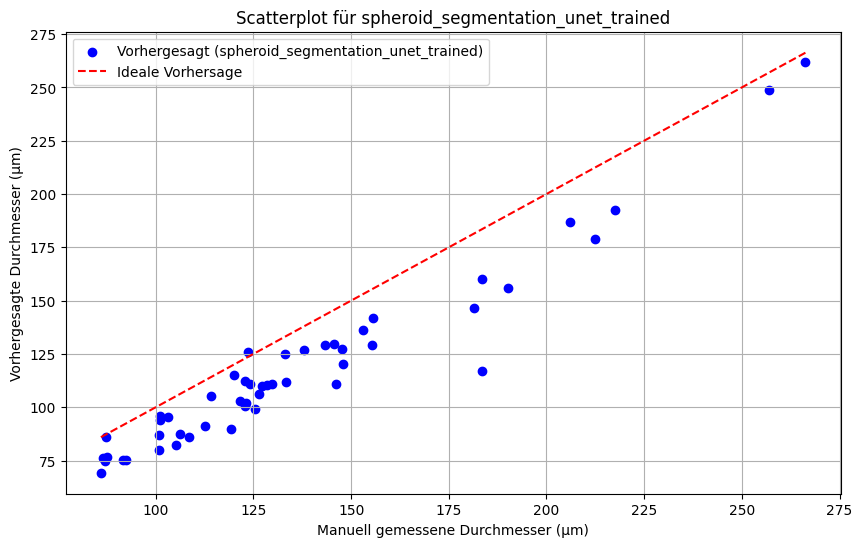

Scatterplot für spheroid_segmentation_unet_trained gespeichert unter: C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/scatter_spheroid_segmentation_unet_trained.png


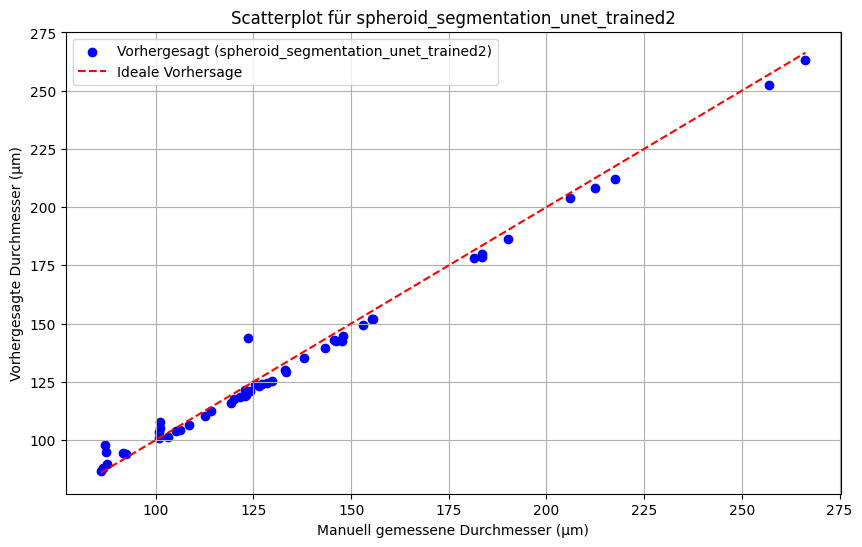

Scatterplot für spheroid_segmentation_unet_trained2 gespeichert unter: C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/scatter_spheroid_segmentation_unet_trained2.png


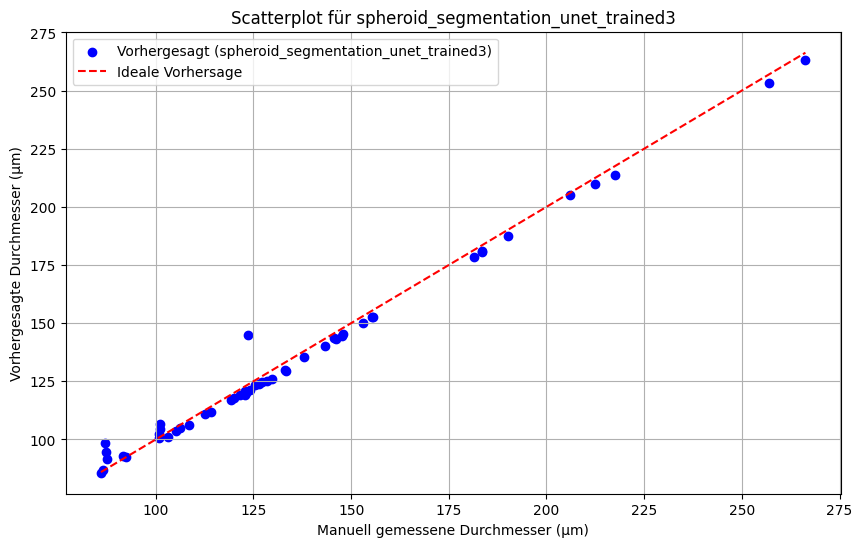

Scatterplot für spheroid_segmentation_unet_trained3 gespeichert unter: C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/scatter_spheroid_segmentation_unet_trained3.png


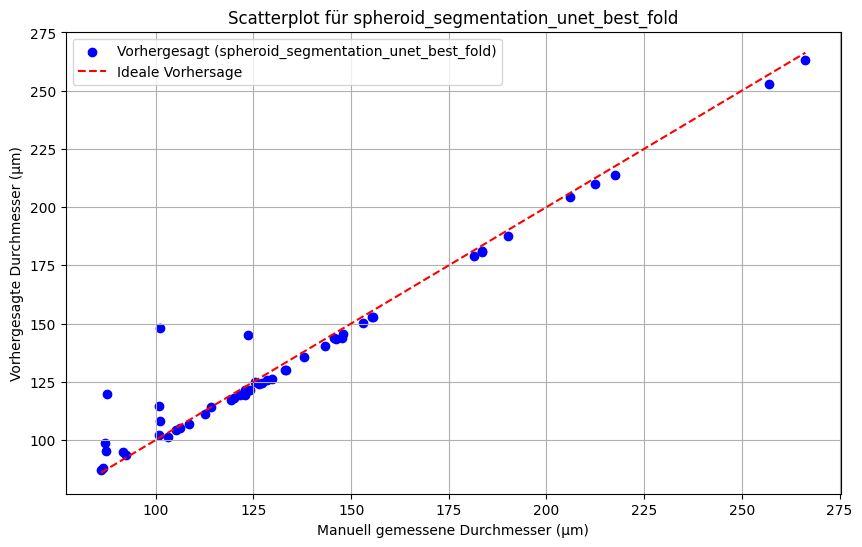

Scatterplot für spheroid_segmentation_unet_best_fold gespeichert unter: C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/scatter_spheroid_segmentation_unet_best_fold.png


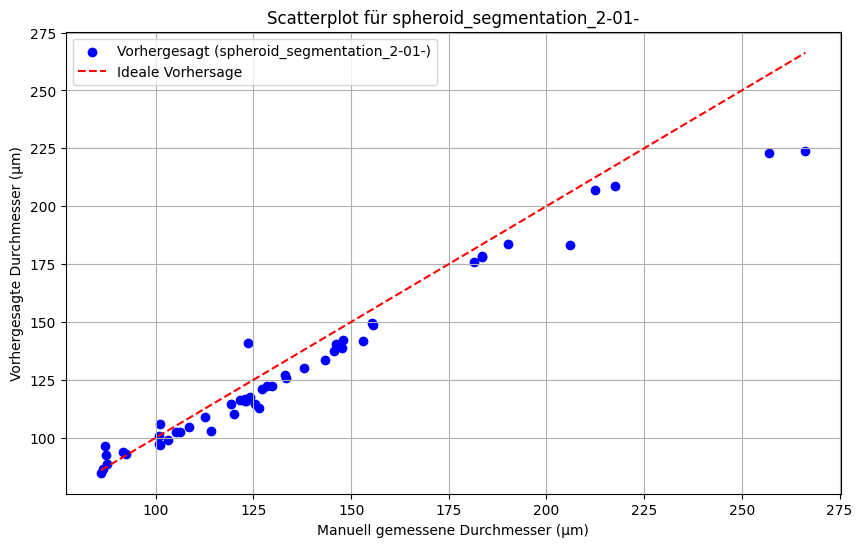

Scatterplot für spheroid_segmentation_2-01- gespeichert unter: C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/scatter_spheroid_segmentation_2-01-.png
Alle Ergebnisse und Scatterplots wurden gespeichert in C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Durchmesser_Liste_Multiple_Modelle.xlsx.
Model: spheroid_segmentation_unet_trained, R²: 0.7403, MAE: 18.3684
Model: spheroid_segmentation_unet_trained2, R²: 0.9873, MAE: 3.6599
Model: spheroid_segmentation_unet_trained3, R²: 0.9887, MAE: 3.1766
Model: spheroid_segmentation_unet_best_fold, R²: 0.9495, MAE: 4.8010
Model: spheroid_segmentation_2-01-, R²: 0.9334, MAE: 7.8015


In [30]:
import os
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Funktionen für Bildbearbeitung und Maskenerstellung
def draw_contours_and_centroid(binary_mask, output_path):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(color_mask, contours, -1, (0, 255, 0), 2)
    
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(color_mask, (cX, cY), 5, (0, 0, 255), -1)
    cv2.imwrite(output_path, color_mask)

# Dice Metric
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Benutzerdefinierte Verlustfunktion
def combined_loss(y_true, y_pred, smooth=1e-6, binary_weight=0.5, dice_weight=0.5):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)
    return binary_weight * bce + dice_weight * dice_loss

# Laden und Vorverarbeiten der Bilder
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((256, 192))
    img = np.array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

# Vorhersage mit dem Modell machen
def predict_with_model(model, image):
    image = np.expand_dims(image, axis=0)
    predicted_mask = model.predict(image)
    return np.squeeze(predicted_mask)

# Funktion zur Berechnung des mittleren Durchmessers
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)

# mit mehreren Modellen vorhersagen und die berechnungen durchführen    
def process_models(model_paths, input_dir, output_dir, excel_file_path, output_excel_path):
    # Excel-Datei laden (manuelle Durchmesser)
    df_manual = pd.read_excel(excel_file_path, header=0)

    # Überprüfen, ob die 'Durchmesser'-Spalte numerische Werte enthält
    df_manual['Durchmesser'] = pd.to_numeric(df_manual['Durchmesser'], errors='coerce')
    df_manual.dropna(subset=['Durchmesser'], inplace=True)

    # Manuelle Durchmesser in eine Liste konvertieren
    manual_diameters = df_manual['Durchmesser'].tolist()

    # Skalierungsfaktoren berechnen
    scale_factor_width = 1296 / 256
    scale_factor_height = 966 / 196

    # TIFF-Dateien laden
    tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

    if len(tif_files) != len(manual_diameters):
        print("Die Anzahl der Bilddateien stimmt nicht mit der Anzahl der manuellen Messungen überein.")
        return

    # Ergebnisse für jedes Modell speichern
    all_predicted_diameters = {}
    metrics = {}

    for model_path in model_paths:
        model_name = os.path.basename(model_path).replace('.h5', '')
        predicted_diameters = []

        # Modell laden und kompilieren (wegen dem custom loss)
        model = load_model(model_path, compile=False)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, binary_weight=0.5, dice_weight=0.5),
                      metrics=[])

        for i, filename in enumerate(tif_files):
            img_path = os.path.join(input_dir, filename)
            try:
                # Bild laden und vorverarbeiten
                image = load_and_preprocess_image_pillow(img_path)
                predicted_mask = predict_with_model(model, image)  # Vorhersage mit dem Modell

                if predicted_mask is None:
                    print(f"Fehler bei der Vorhersage für {filename}.")
                    continue

                contours, _ = cv2.findContours((predicted_mask > 0.5).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

                if not contours:
                    print(f"Keine Konturen im Bild {filename} gefunden.")
                    continue

                largest_contour = max(contours, key=cv2.contourArea)
                M = cv2.moments(largest_contour)
                if M["m00"] == 0:
                    print(f"Momentenberechnung ergibt 0 für Bild {filename}.")
                    continue
                center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

                avg_diameter_pixels = calculate_average_diameter(largest_contour, center)
                avg_diameter_micrometers = avg_diameter_pixels * (0.3745 * scale_factor_width) * 0.994

                # Print-Anweisung für die berechneten Durchmesser
                print(f"Bild: {filename}, Durchmesser (Pixel): {avg_diameter_pixels}, Durchmesser (µm): {avg_diameter_micrometers}")

                predicted_diameters.append(avg_diameter_micrometers)

                output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_{model_name}_segmentiert.tif")
                draw_contours_and_centroid((predicted_mask > 0.5).astype(np.uint8) * 255, output_path)

            except Exception as e:
                print(f"Fehler bei der Verarbeitung von {filename}: {e}")

        all_predicted_diameters[model_name] = predicted_diameters

        # Berechnung der Metriken 
        r2 = r2_score(manual_diameters, predicted_diameters)
        mae = mean_absolute_error(manual_diameters, predicted_diameters)
        metrics[model_name] = {'R²': r2, 'MAE': mae}

        print(f"Model: {model_name}, Anzahl der vorhergesagten Durchmesser: {len(predicted_diameters)}, Werte: {predicted_diameters}")

    # Scatterplot für alle Modelle erstellen
    create_scatterplots(manual_diameters, all_predicted_diameters, metrics, output_dir)

    # Ergebnisse in DataFrame konvertieren und exportieren
    df_results = pd.DataFrame(all_predicted_diameters)
    df_results.insert(0, 'Manuell gemessene Durchmesser (µm)', manual_diameters)
    df_results.to_excel(output_excel_path, index=False)

    print(f"Alle Ergebnisse und Scatterplots wurden gespeichert in {output_excel_path}.")

    # Metriken ausgeben
    for model_name, metric in metrics.items():
        print(f"Model: {model_name}, R²: {metric['R²']:.4f}, MAE: {metric['MAE']:.4f}")

# Funktion zum Erstellen von Scatterplots
def create_scatterplots(manual_diameters, all_predicted_diameters, metrics, output_dir):
    for model_name, predicted_diameters in all_predicted_diameters.items():
        plt.figure(figsize=(10, 6))
        plt.scatter(manual_diameters, predicted_diameters, color='blue', label=f'Vorhergesagt ({model_name})')
        plt.plot([min(manual_diameters), max(manual_diameters)], [min(manual_diameters), max(manual_diameters)], color='red', linestyle='--', label='Ideale Vorhersage')
        plt.xlabel('Manuell gemessene Durchmesser (µm)')
        plt.ylabel('Vorhergesagte Durchmesser (µm)')
        plt.title(f'Scatterplot für {model_name}')
        plt.legend()
        plt.grid(True)

        scatter_output_path = os.path.join(output_dir, f'scatter_{model_name}.png')
        plt.savefig(scatter_output_path)
        plt.show()
        plt.close()
        print(f"Scatterplot für {model_name} gespeichert unter: {scatter_output_path}")

model_paths = [
    'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained.h5',
    'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained2.h5',
    'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained3.h5',
    "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_best_fold.h5",
    #"C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_2-05-combo_loss.h5",
    #"C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_2-05-combo_loss2.h5",
    "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_2-01-.h5",
    #"C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_2-03-.h5", # bei einigen keine konturen gefunden
    #"C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_2-0-.h5",  selbes problem wie darüber
]

input_dir = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testset von julia"
output_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/'
excel_file_path = 'C:/Users/chris/Documents/Testset.xlsx'
output_excel_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Durchmesser_Liste_Multiple_Modelle.xlsx'

process_models(model_paths, input_dir, output_dir, excel_file_path, output_excel_path)


Anzahl der manuellen Durchmesser: 50
Anzahl der TIFF-Dateien: 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step

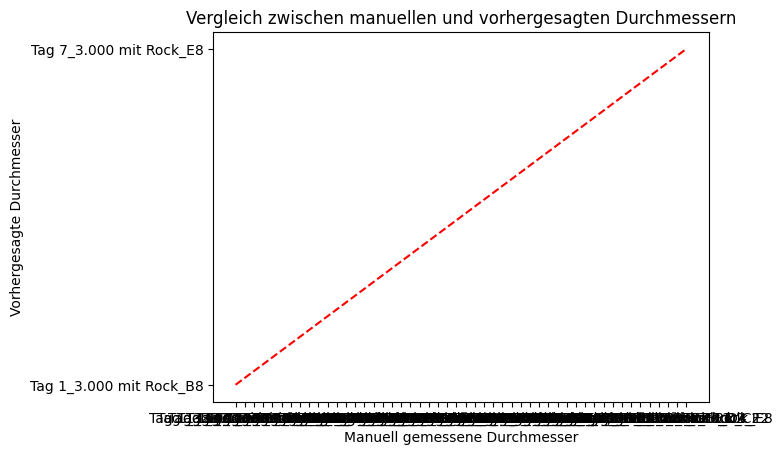

ValueError: dtype='numeric' is not compatible with arrays of bytes/strings.Convert your data to numeric values explicitly instead.

In [6]:
import os
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Dice Loss Funktion
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

# Combo Loss Funktion (Binary Crossentropy + Dice Loss)
def combo_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

# Dice Loss als Metrik
def dice_metric(y_true, y_pred):
    return dice_loss(y_true, y_pred)

# Funktion zum Zeichnen von Konturen und Schwerpunkt
def draw_contours_and_centroid(binary_mask, output_path):
    # Finden der Konturen
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Erstellen eines Farbbilds zum Zeichnen
    color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    
    # Zeichnen der Konturen
    cv2.drawContours(color_mask, contours, -1, (0, 255, 0), 2)
    
    # Berechnung und Zeichnen des Schwerpunkts
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(color_mask, (cX, cY), 5, (0, 0, 255), -1)
    
    # Speichern des Bildes mit Konturen und Schwerpunkt
    cv2.imwrite(output_path, color_mask)

# Laden und Vorverarbeiten der Bilder mit Pillow
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize((256, 196))  # Größe anpassen (Beispiel: 256x196)
    img = np.array(img)  # PIL Image zu numpy Array konvertieren
    img = img / 255.0  # Normalisierung auf den Bereich [0, 1]
    img = np.expand_dims(img, axis=-1)  # Für einen Kanal (Grayscale)
    return img

# Vorhersage mit dem Modell machen
def predict_with_model(model, image):
    image = np.expand_dims(image, axis=0)  # Batch-Dimension hinzufügen
    predicted_mask = model.predict(image)  # Vorhersage machen
    return np.squeeze(predicted_mask)  # Batch-Dimension entfernen

# Funktion zur Berechnung der mittleren Konturgröße
def calculate_average_contour_size(contour):
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return 0
    return cv2.contourArea(contour) / perimeter

# Funktion zur Auswahl des besten Schwellenwerts
def find_best_threshold(mask):
    best_threshold = 0
    best_score = 0

    for threshold in np.arange(0.1, 0.5, 0.01):
        binary_mask = (mask > threshold).astype(np.uint8) * 255  # Binarisieren und in 8-bit konvertieren
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            avg_size = calculate_average_contour_size(largest_contour)
            score = avg_size  # Anpassen der Bewertungsmetrik nach Bedarf

            if score > best_score:
                best_score = score
                best_threshold = threshold

    return best_threshold

# Funktion zur Berechnung des mittleren Durchmessers
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)

# Pfade definieren
model_path = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_2-05-combo_loss.h5"
input_dir = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testset von julia"
output_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/'
excel_file_path = 'C:/Users/chris/Documents/Testset.xlsx'

# Modell mit den benutzerdefinierten Loss-Funktionen und Metriken laden
custom_objects = {
    'dice_loss': dice_loss,
    'combo_loss': combo_loss,
    'dice_metric': dice_metric
}

model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# Daten aus der Excel-Tabelle laden
predicted_diameters = []
df_manual = pd.read_excel(excel_file_path, header=0)  # Daten ab der zweiten Zeile 
manual_diameters = df_manual.iloc[:, 1].tolist()  # Durchmesser sind in der zweiten Spalte

# Debug-Ausgabe: Anzahl der manuellen Durchmesser
print(f"Anzahl der manuellen Durchmesser: {len(df_manual)}")

# Skalierungsfaktoren berechnen
scale_factor_width = 1296 / 256  # Originalbreite / skalierte Breite
scale_factor_height = 966 / 196  # Originalhöhe / skalierte Höhe

# Listen für die berechneten Durchmesser und die manuell gemessenen Durchmesser
predicted_diameters = []  # Hier werden die vorhergesagten Durchmesser gespeichert

# Iteration über alle TIFF-Dateien im Eingabeordner
tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

# Debug-Ausgabe: Anzahl der TIFF-Dateien
print(f"Anzahl der TIFF-Dateien: {len(tif_files)}")

# Überprüfen, ob die Anzahl der Dateien mit der Anzahl der manuellen Messungen übereinstimmt
if len(tif_files) != len(df_manual):
    print("Die Anzahl der Bilddateien stimmt nicht mit der Anzahl der manuellen Messungen überein.")
else:
    for i, filename in enumerate(tif_files):
        img_path = os.path.join(input_dir, filename)
        
        try:
            # Bild laden und vorverarbeiten
            image = load_and_preprocess_image_pillow(img_path)
            # Vorhersage mit dem Modell machen
            predicted_mask = predict_with_model(model, image)
            if predicted_mask is None:
                print(f"Fehler bei der Vorhersage für {filename}.")
                continue

            # Besten Schwellenwert für Konturen finden
            best_threshold = find_best_threshold(predicted_mask)

            # Maske mit dem besten Schwellenwert erstellen
            binary_mask = (predicted_mask > best_threshold).astype(np.uint8) * 255  # Binarisieren und in 8-bit konvertieren
            
            # Konturen finden
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            if not contours:
                print(f"Keine Konturen im Bild {filename} gefunden. Setze Durchmesser auf 0.")
                predicted_diameters.append(0)  # Setze den Durchmesser auf 0, wenn keine Konturen gefunden werden
                continue

            # Filtere Konturen nach Schmalheitsverhältnis
            filtered_contours = []
            for contour in contours:
                area = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)
                if perimeter == 0:
                    continue
                circularity = 4 * np.pi * (area / (perimeter * perimeter))
                if circularity > 0.5:  # Anpassen des Schmalheitsverhältnisses nach Bedarf
                    filtered_contours.append(contour)

            if not filtered_contours:
                print(f"Keine geeigneten Konturen im Bild {filename} gefunden.")
                predicted_diameters.append(0)  # Setze den Durchmesser auf 0, wenn keine geeigneten Konturen gefunden werden
                continue

            # Die größte Kontur nach dem Flächeninhalt finden
            largest_contour = max(filtered_contours, key=cv2.contourArea)
            
            # Schwerpunkt der größten Kontur berechnen
            M = cv2.moments(largest_contour)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroid = (cX, cY)

            # Mittleren Durchmesser berechnen
            avg_diameter = calculate_average_diameter(largest_contour, centroid)

            # Durchmesser in die ursprüngliche Auflösung skalieren
            scaled_diameter = avg_diameter * (scale_factor_width + scale_factor_height) / 2

            # Ergebnis in der Liste der vorhergesagten Durchmesser speichern
            predicted_diameters.append(scaled_diameter)

            # Ergebnisbild mit Konturen und Schwerpunkt speichern
            output_path = os.path.join(output_dir, f"segmented_{filename}")
            draw_contours_and_centroid(binary_mask, output_path)

        except Exception as e:
            print(f"Fehler bei der Verarbeitung von {filename}: {e}")
            continue

# Berechnete Durchmesser und manuelle Durchmesser als Diagramm plotten
plt.scatter(manual_diameters, predicted_diameters, color='blue')
plt.plot([min(manual_diameters), max(manual_diameters)], [min(manual_diameters), max(manual_diameters)], color='red', linestyle='--')
plt.xlabel("Manuell gemessene Durchmesser")
plt.ylabel("Vorhergesagte Durchmesser")
plt.title("Vergleich zwischen manuellen und vorhergesagten Durchmessern")
plt.show()

# Berechnung und Ausgabe der Fehlermaße
mae = mean_absolute_error(manual_diameters, predicted_diameters)
mse = mean_squared_error(manual_diameters, predicted_diameters)
r2 = r2_score(manual_diameters, predicted_diameters)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")


In [7]:
import os
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Dice Loss Funktion
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

# Combo Loss Funktion (Binary Crossentropy + Dice Loss)
def combo_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

# Dice Loss als Metrik
def dice_metric(y_true, y_pred):
    return dice_loss(y_true, y_pred)

# Funktion zum Zeichnen von Konturen und Schwerpunkt
def draw_contours_and_centroid(binary_mask, output_path):
    # Finden der Konturen
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Erstellen eines Farbbilds zum Zeichnen
    color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    
    # Zeichnen der Konturen
    cv2.drawContours(color_mask, contours, -1, (0, 255, 0), 2)
    
    # Berechnung und Zeichnen des Schwerpunkts
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(color_mask, (cX, cY), 5, (0, 0, 255), -1)
    
    # Speichern des Bildes mit Konturen und Schwerpunkt
    cv2.imwrite(output_path, color_mask)

# Laden und Vorverarbeiten der Bilder mit Pillow
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize((256, 196))  # Größe anpassen (Beispiel: 256x196)
    img = np.array(img)  # PIL Image zu numpy Array konvertieren
    img = img / 255.0  # Normalisierung auf den Bereich [0, 1]
    img = np.expand_dims(img, axis=-1)  # Für einen Kanal (Grayscale)
    return img

# Vorhersage mit dem Modell machen
def predict_with_model(model, image):
    image = np.expand_dims(image, axis=0)  # Batch-Dimension hinzufügen
    predicted_mask = model.predict(image)  # Vorhersage machen
    return np.squeeze(predicted_mask)  # Batch-Dimension entfernen

# Funktion zur Berechnung der mittleren Konturgröße
def calculate_average_contour_size(contour):
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return 0
    return cv2.contourArea(contour) / perimeter

# Funktion zur Auswahl des besten Schwellenwerts
def find_best_threshold(mask):
    best_threshold = 0
    best_score = 0

    for threshold in np.arange(0.1, 0.5, 0.01):
        binary_mask = (mask > threshold).astype(np.uint8) * 255  # Binarisieren und in 8-bit konvertieren
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            avg_size = calculate_average_contour_size(largest_contour)
            score = avg_size  # Anpassen der Bewertungsmetrik nach Bedarf

            if score > best_score:
                best_score = score
                best_threshold = threshold

    return best_threshold

# Funktion zur Berechnung des mittleren Durchmessers
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)

# Pfade definieren
model_path = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_2-05-combo_loss.h5"
input_dir = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testset von julia"
output_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/'
excel_file_path = 'C:/Users/chris/Documents/Testset.xlsx'

# Modell mit den benutzerdefinierten Loss-Funktionen und Metriken laden
custom_objects = {
    'dice_loss': dice_loss,
    'combo_loss': combo_loss,
    'dice_metric': dice_metric
}

model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# Daten aus der Excel-Tabelle laden
predicted_diameters = []
df_manual = pd.read_excel(excel_file_path, header=0)  # Daten ab der zweiten Zeile 
manual_diameters = df_manual.iloc[:, 1].tolist()  # Durchmesser sind in der zweiten Spalte

# Debug-Ausgabe: Anzahl der manuellen Durchmesser
print(f"Anzahl der manuellen Durchmesser: {len(df_manual)}")

# Skalierungsfaktoren berechnen
scale_factor_width = 1296 / 256  # Originalbreite / skalierte Breite
scale_factor_height = 966 / 196  # Originalhöhe / skalierte Höhe

# Listen für die berechneten Durchmesser und die manuell gemessenen Durchmesser
predicted_diameters = []

# Iteration über alle TIFF-Dateien im Eingabeordner
tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

# Debug-Ausgabe: Anzahl der TIFF-Dateien
print(f"Anzahl der TIFF-Dateien: {len(tif_files)}")

# Überprüfen, ob die Anzahl der Dateien mit der Anzahl der manuellen Messungen übereinstimmt
if len(tif_files) != len(df_manual):
    print("Die Anzahl der Bilddateien stimmt nicht mit der Anzahl der manuellen Messungen überein.")
else:
    for i, filename in enumerate(tif_files):
        img_path = os.path.join(input_dir, filename)
        
        try:
            # Bild laden und vorverarbeiten
            image = load_and_preprocess_image_pillow(img_path)
            # Vorhersage mit dem Modell machen
            predicted_mask = predict_with_model(model, image)
            if predicted_mask is None:
                print(f"Fehler bei der Vorhersage für {filename}.")
                continue

            # Besten Schwellenwert für Konturen finden
            best_threshold = find_best_threshold(predicted_mask)

            # Maske mit dem besten Schwellenwert erstellen
            binary_mask = (predicted_mask > best_threshold).astype(np.uint8) * 255  # Binarisieren und in 8-bit konvertieren
            
            # Konturen finden
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            if not contours:
                print(f"Keine Konturen im Bild {filename} gefunden.")
                predicted_diameters.append(0)  # Wenn keine Konturen gefunden, 0 hinzufügen
                continue

            # Filtere Konturen nach Schmalheitsverhältnis
            filtered_contours = []
            for contour in contours:
                area = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)
                if perimeter == 0:
                    continue
                circularity = 4 * np.pi * (area / (perimeter * perimeter))
                if circularity > 0.5:  # Anpassen des Schmalheitsverhältnisses nach Bedarf
                    filtered_contours.append(contour)

            if not filtered_contours:
                print(f"Keine geeigneten Konturen im Bild {filename} gefunden.")
                predicted_diameters.append(0)  # Wenn keine geeigneten Konturen gefunden, 0 hinzufügen
                continue

            # Berechnung der Durchmesser für die gefilterten Konturen
            diameters = []
            for contour in filtered_contours:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    diameter = calculate_average_diameter(contour, (cX, cY))
                    diameters.append(diameter)

            if diameters:
                # Durchmesser durchschnittlich berechnen und zur Liste hinzufügen
                average_diameter = np.mean(diameters)
                predicted_diameters.append(average_diameter * scale_factor_width)  # Durchmesser auf ursprüngliche Größe skalieren

                # Debug-Ausgabe: Durchmesser
                print(f"Durchmesser für {filename}: {average_diameter * scale_factor_width}")
                
                # Bild mit Konturen und Schwerpunkten zeichnen
                output_path = os.path.join(output_dir, f"contours_{filename}")
                draw_contours_and_centroid(binary_mask, output_path)

            else:
                print(f"Keine Durchmesser für Bild {filename} gefunden.")
                predicted_diameters.append(0)  # Wenn keine Durchmesser gefunden, 0 hinzufügen

        except Exception as e:
            print(f"Fehler beim Verarbeiten von {filename}: {e}")
            predicted_diameters.append(0)  # Im Fehlerfall 0 hinzufügen

# Berechnung und Ausgabe der Fehlermaße
# Konvertiere die Listen in Float-Arrays
manual_diameters = [float(d) for d in manual_diameters]
predicted_diameters = [float(d) for d in predicted_diameters]

# Berechnung der Fehlermaße
mae = mean_absolute_error(manual_diameters, predicted_diameters)
mse = mean_squared_error(manual_diameters, predicted_diameters)
r2 = r2_score(manual_diameters, predicted_diameters)

# Ausgabe der Fehlermaße
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

# Visualisierung der Ergebnisse
plt.figure(figsize=(10, 6))
plt.scatter(manual_diameters, predicted_diameters, color='blue', label='Predicted vs. Manual')
plt.plot([min(manual_diameters), max(manual_diameters)], [min(manual_diameters), max(manual_diameters)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Manual Diameters')
plt.ylabel('Predicted Diameters')
plt.title('Comparison of Manual and Predicted Diameters')
plt.legend()
plt.grid()
plt.show()


Anzahl der manuellen Durchmesser: 50
Anzahl der TIFF-Dateien: 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
Durchmesser für hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_B8_ch00.tif: 1261.429798634122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
Durchmesser für hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_D7_ch00.tif: 1261.429798634122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Durchmesser für hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_E7_ch00.tif: 1261.429798634122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
Durchmesser für hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_E8_ch00.tif: 1261.429798634122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Durchmesser für hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_F7_ch00.tif: 1261.429798634122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
Durchmesser für hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_F8_ch0

ValueError: could not convert string to float: 'Tag 1_3.000 mit Rock_B8'

In [19]:
from tensorflow.keras.models import load_model

model = load_model('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained.h5', compile=False)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 192, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 192, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 192, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 96, 128,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 96, 128,   │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 96, 128,   │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 128,   │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 96, 128,   │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 128,   │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 48, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 48, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 48, 64,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 48, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 64,    │      1,024 │ conv2d_5[0][0]  

 Total params: 4,608,193 (17.58 MB)

 Trainable params: 4,603,457 (17.56 MB)

 Non-trainable params: 4,736 (18.50 KB)